# Dedalus simulations for microfluidics experiments

Using the parameters obtained from the PINNs (KdVBurgers_PINN.ipynb), we simulate from experimental initial conditions and plot the results

This is a notebook in which we train PINNs to test hypotheses about models for the microfluidic particles experiments and also learn parameters for those equations

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
y0 = np.load('data/rescaled_1d.npy', mmap_mode='r')

frame_rate = 60 / 4
pixel_size = 18 / (y0.shape[1]) #mm
Dx = pixel_size
Dt = 1 / frame_rate

tmin, xmin = 0, 0
tmax = y0.shape[0] / frame_rate
xmax = y0.shape[1] * pixel_size

TT = np.linspace(tmin, tmax, y0.shape[0])
XX = np.linspace(xmin, xmax, y0.shape[1])

N, Nt, Nx = y0.shape[1], 112, 200

print(y0.shape, Nt, Nx)

(112, 200) 112 200


## Plot results

In [3]:
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.titlepad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['font.size'] = 6
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.25
plt.rcParams['image.origin'] = 'upper'
plt.rcParams['image.cmap'] = 'magma'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['savefig.format'] = 'svg'
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.transparent'] = True
plt.rcParams['savefig.pad_inches'] = 0.1
plt.rcParams['savefig.dpi'] = 200

savedir = 'Figures'

y0 = np.load('data/rescaled_1d.npy', mmap_mode='r')
y_gfnn = np.load('data/gfnn_y.npy')
y_b = np.load('data/burgers_dedalus.npy')
y_kdv = np.load('data/kdv_dedalus.npy')
y_kdvb = np.load('data/kdvb_dedalus.npy')

from scipy.integrate import cumtrapz
A, B, D, C = 2.792, -1.592, 0.233, 0
phi = np.exp(cumtrapz(y_b, dx=pixel_size, initial=0) * B / (2 * D)) #Get Cole-Hopf variables

def plot_density_field(ax, rho, kwargs):
    #Note - video flows right to left, but we present things left to right
    im = ax.imshow(rho[:, ::-1], **kwargs)
    ax.set_aspect('auto')
    ax.set(xlabel='$x$ (mm)', xticks=[0, 4, 8], xlim=[0, 10],
           ylabel='$t$ (s)', yticks=[0, 2], ylim=[4, 0])
    cbax = inset_axes(ax, width=0.3, height=0.05, loc='upper right')
    cbar = plt.colorbar(im, cax=cbax, ticks=[0,1], orientation='horizontal')
    color='y'
    fontsize=plt.rcParams['font.size'] - 1
    cbar.ax.set_xlabel('$\\rho$', fontsize=fontsize, color=color, labelpad=0.5)
    cbar.ax.set_xticklabels([0, 1], fontsize=fontsize, color=color)
    cbar.outline.set_edgecolor(color)
    cbar.outline.set_linewidth(0.5)
    cbar.ax.xaxis.set_tick_params(color='y', width=0.5, pad=1)
    plt.setp(plt.getp(cbax, 'xticklabels'), color=color)

def MAE(input, target):
    return np.mean(np.abs(input - target))
def rMAE(input, target):
    return MAE(input, target) / np.mean(np.abs(target))

def fwhm(f, dx=pixel_size):
    #f is f[T, X]
    fmax = np.max(f)
    half_max = fmax / 2
    above = np.argwhere(f >= half_max)
    
    left = above.min()
    right = above.max()
    return (right - left) * dx

In the predicted region
Burgers:	MAE=0.067, r-MAE=0.150
KdV:		MAE=0.106, r-MAE=0.239
KdV-B:		MAE=0.068, r-MAE=0.153

In the vicinity of the shock
Burgers:	MAE=0.074, r-MAE=0.095
KdV:		MAE=0.137, r-MAE=0.176
KdV-B:		MAE=0.067, r-MAE=0.086


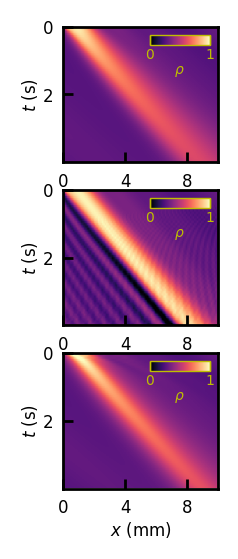

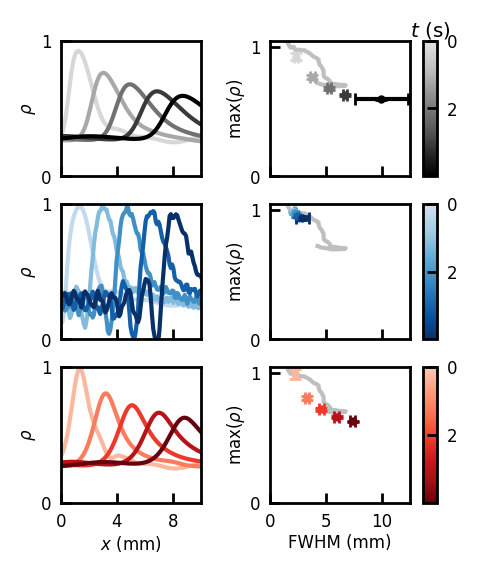

In [4]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

kwargs = dict(extent=[xmin, xmax, tmax, tmin], vmin=0, vmax=1)

mask = np.zeros(y0.shape, dtype=bool)
mask[:50, -100:] = 1
print('In the predicted region')
print(f'Burgers:\tMAE={MAE(y_b[mask], y0[mask]):.3f}, r-MAE={rMAE(y_b[mask], y0[mask]):.3f}')
print(f'KdV:\t\tMAE={MAE(y_kdv[mask], y0[mask]):.3f}, r-MAE={rMAE(y_kdv[mask], y0[mask]):.3f}')
print(f'KdV-B:\t\tMAE={MAE(y_kdvb[mask], y0[mask]):.3f}, r-MAE={rMAE(y_kdvb[mask], y0[mask]):.3f}')

#Fit a line through the maxes of y0 in order to define a shock mask
maxes = np.argmax(y0, axis=1)
max_X = XX[maxes]
fit = np.polyfit(TT, max_X, deg=1)
max_X = TT * fit[0] + fit[1]

diff = XX[None, :] - max_X[:, None]

width = 1
mask[np.abs(diff) > width/2] = 0

print('\nIn the vicinity of the shock')
print(f'Burgers:\tMAE={MAE(y_b[mask], y0[mask]):.3f}, r-MAE={rMAE(y_b[mask], y0[mask]):.3f}')
print(f'KdV:\t\tMAE={MAE(y_kdv[mask], y0[mask]):.3f}, r-MAE={rMAE(y_kdv[mask], y0[mask]):.3f}')
print(f'KdV-B:\t\tMAE={MAE(y_kdvb[mask], y0[mask]):.3f}, r-MAE={rMAE(y_kdvb[mask], y0[mask]):.3f}')

fig1, ax1 = plt.subplots(3, 1, figsize=(1., 3), dpi=200)
fig2, ax2 = plt.subplots(3, 2, figsize=(2.25, 3), dpi=200,
                         sharex='col', sharey='col')
    
labels = ['Burgers\'', 'KdV', 'KdV-Burgers\'']
cmaps  = ['Greys', 'Blues', 'Reds']

xlim = [0, 10]
ylim = [4, 0]
offset = 1
norm = matplotlib.colors.Normalize(vmin=ylim[1]-offset, vmax=ylim[0])

mask = np.abs(diff) <= width/2
mask = mask.astype(float)
mask[mask == 0] = 0.5
#kwargs['alpha'] = mask[:, ::-1]

for i, yy in enumerate([y_b, y_kdv, y_kdvb]):
    plot_density_field(ax1[i], yy, kwargs)
    ax1[i].set(xlim=xlim, ylim=ylim)

    sm = plt.cm.ScalarMappable(cmap=cmaps[i], norm=norm)
    slices = np.linspace(0.3, 4, 5)
    colors = sm.to_rgba(slices)

    max_y = np.max(yy, axis=1)
    
    for j, tt in enumerate(slices):
        color = colors[j]
        ii = np.argmin(np.abs(TT - tt))
        ax2[i, 0].plot(XX, yy[ii, ::-1], color=color)

        # use the neighboring three time-points to compute error bars
        grp = yy[ii-3:ii+4, :]
        width = np.apply_along_axis(fwhm, 1, grp)
        peak = np.max(grp, axis=1)
        ax2[i, 1].errorbar(width.mean(), peak.mean(), 
                      xerr=width.std(), yerr=peak.std(), 
                      linestyle='', color=color, 
                      marker='o', markersize=2, capsize=2)

    grp = y_gfnn
    width = np.apply_along_axis(fwhm, 1, grp)
    peak = np.max(grp, axis=1)
    ax2[i, 1].plot(width, peak, color='grey', linestyle='-', zorder=-1, alpha=0.5)
    
    ax2[i, 0].set_ylabel('$\\rho$')
    ax2[i, 0].set_xlim(ax1[i].get_xlim())
    ax2[i, 0].set_ylim([0, 1])
    ax2[i, 0].set(xticks=ax1[i].get_xticks(), yticks=[0, 1])

    ax2[i, 1].set_ylabel('$\max(\\rho)$')
    ax2[i, 1].set_yticks([0, 1])
    ax2[i, 1].set_xlim([0, 12.5])
    ax2[i, 1].set_xticks([0, 5, 10])
    #ax2[i,1].set_xlim([0, 8.5])

    fig2.subplots_adjust(right=0.9, wspace=0.5)
    bot = ax2[i, 0].get_position().y0
    dy = ax2[i, 0].get_position().y1 - bot
    cax = fig2.add_axes([0.93, bot, 0.03, dy])
    
    cbar = plt.colorbar(sm, cax=cax, ticks=[0, 2], aspect=10)
    cax.set_ylim(ylim)
    if i == 0:
        cax.set_title('$t$ (s)')
    if i == 2:
        ax2[i, 0].set_xlabel('$x$ (mm)')
        ax2[i, 1].set_xlabel('FWHM (mm)')


#fig1.savefig(f'{savedir}/OptimizedKdVB_densityfield')
#fig2.savefig(f'{savedir}/OptimizedKdVB_densitytime')

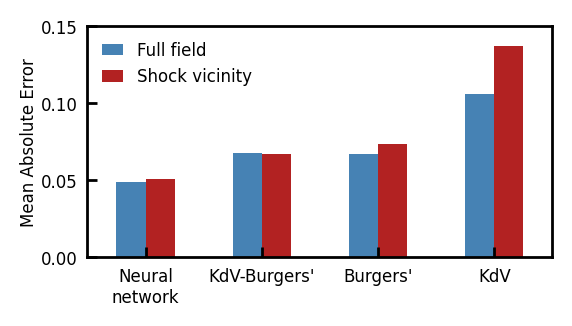

In [27]:
'''
Copied from above cell
----------------------
In the predicted region
Burgers:	MAE=0.067, r-MAE=0.150
KdV:		MAE=0.106, r-MAE=0.239
KdV-B:		MAE=0.068, r-MAE=0.153

In the vicinity of the shock
Burgers:	MAE=0.074, r-MAE=0.095
KdV:		MAE=0.137, r-MAE=0.176
KdV-B:		MAE=0.067, r-MAE=0.086

Copied from NeuralOperator_Postprocessing.ipynb
-----------------------------------------------
GFNN:	MAE=0.049, r-MAE=0.110
Near shock:	MAE=0.051, r-MAE=0.066
Mean field:	MAE=0.172, r-MAE=0.385
Mean field near shock:	MAE=0.337, r-MAE=0.430
'''
import pandas as pd

results = pd.DataFrame({
    'Solution': ['Neural\nnetwork', 'Burgers\'', 'KdV', 'KdV-Burgers\'', 'Baseline'],
    'Full field': [0.049, 0.067, 0.106, 0.068, 0.172],
    'Shock vicinity': [0.051, 0.074, 0.137, 0.067, 0.337]
}).set_index('Solution').drop('Baseline')
results = results.loc[['Neural\nnetwork', 'KdV-Burgers\'', 'Burgers\'', 'KdV']]

fig, ax = plt.subplots(1, 1, dpi=200, figsize=(3,1.5))

ax = results.plot.bar(ax=ax, rot=0, color=['steelblue', 'firebrick'])
ax.set_xlabel('')
ax.set_yticks([0, 0.05, 0.1, 0.15])
#ax.set_yticks([0, 0.1, 0.2, 0.3])
ax.set_ylabel('Mean Absolute Error')

fig.savefig('Figures/ErrorRate_Barplot.svg', bbox_inches='tight')

[0, 5, 15, 25, 35]
At t = 0 s, Peak at 0.905 mm
At t = 0.333 s, Peak at 1.36 mm
At t = 1 s, Peak at 2.62 mm
At t = 1.67 s, Peak at 3.98 mm
At t = 2.33 s, Peak at 5.34 mm


(2.3333333333333335, 0.0)

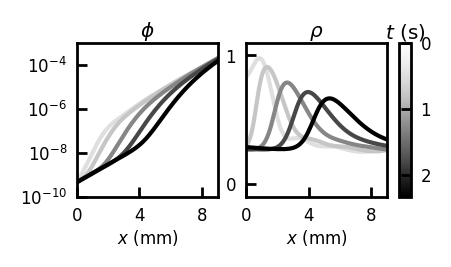

In [11]:
fig1, ax1 = plt.subplots(1, 2, figsize=(2, 1), dpi=200, 
                         sharex=True,
                         constrained_layout=False)

x = np.linspace(xmin, xmax, y_b.shape[1])
ts = [0, 5, 15, 25, 35]
print(ts)

offset = 10
colors = [plt.cm.Greys((j+offset) / (ts[-1]+offset)) for j in ts]
for (t, color) in zip(ts, colors):
    ax1[0].plot(x[1:-1], phi[t, ::-1][1:-1], c=color)
    ax1[1].plot(x[1:-1], y_b[t, ::-1][1:-1], c=color)
    
    print(f'At t = {t / frame_rate:.3g} s, Peak at {x[np.argmax(y_b[t, ::-1])]:.3g} mm')
    
'''
Formatting
'''
ax1[0].set_title('$\\phi$')
ax1[1].set_title('$\\rho$')
ax1[1].set(ylim=[-0.1, 1.1], yticks=[0, 1], xlim=[0, 9], xticks=[0, 4, 8])

ax1[0].set(xlabel='$x$ (mm)', yscale='log', ylim=[1e-10, 1e-3])
ax1[1].set(xlabel='$x$ (mm)')


'''
Colorbars
'''
fig1.subplots_adjust(right=0.9)
norm = matplotlib.colors.Normalize(vmin=0, vmax=ts[-1] / frame_rate)

y0 = ax1[1].get_position().y0
dy = ax1[1].get_position().y1 - y0
cax = fig1.add_axes([0.93, y0, 0.03, dy])
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='Greys', norm=norm),
                    cax=cax, ticks=[0, 1, 2])
cbar.ax.set_title('$t$ (s)')
cbar.ax.set_ylim(cbar.ax.get_ylim()[::-1])

#fig1.savefig(f'{savedir}/Burgers_variables')

## Generate simulations using dedalus

In [48]:
import dedalus.public as d3
from scipy.interpolate import interp1d, RectBivariateSpline
from scipy.integrate import cumtrapz

import logging
logger = logging.getLogger(__name__)

def integrate(A,B,D,C, Nx=512, timestep=2e-3, save_every=25):
    # Bases
    xcoord = d3.Coordinate('x')
    dist = d3.Distributor(xcoord, dtype=np.float64)
    xbasis = d3.RealFourier(xcoord, size=Nx, bounds=(0, xmax), dealias=3/2)

    # Fields
    u = dist.Field(name='u', bases=xbasis)

    # Substitutions
    grad = lambda A: d3.Differentiate(A, xcoord)

    # Problem
    problem = d3.IVP([u], namespace=locals())
    problem.add_equation("dt(u) - A*grad(u) - D*grad(grad(u)) - C*grad(grad(grad(u))) = B*u*grad(u)")

    # Initial conditions
    x = dist.local_grid(xbasis)
    u['g'] = interp1d(XX, y0[0], fill_value='extrapolate')(x)

    # Solver
    solver = problem.build_solver(d3.SBDF2)
    solver.stop_sim_time = tmax

    # Main loop
    u.change_scales(1)
    u_list = [np.copy(u['g'])]
    t_list = [solver.sim_time]
    while solver.proceed:
        solver.step(timestep)
        if solver.iteration % 1000 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
        if solver.iteration % 25 == 0:
            u.change_scales(1)
            u_list.append(np.copy(u['g']))
            t_list.append(solver.sim_time)

    y = RectBivariateSpline(t_list, x, np.stack(u_list))(TT, XX)
    return y

# Parameters come from PINN investigation
A, B, D, C = 2.792, -1.592, 0.233, 0
y_b = integrate(A, B, D, C)
phi = np.exp(cumtrapz(y_b, dx=pixel_size, initial=0) * B / (2 * D)) #Get Cole-Hopf variables

A, B, D, C = 2.136, -0.361, 0, 0.010
y_kdv = integrate(A, B, D, C)

A, B, D, C = 3.260, -2.688, 0.212, -0.115
y_kdvb = integrate(A, B, D, C)

np.save('data/burgers_dedalus', y_b)
np.save('data/kdv_dedalus', y_kdv)
np.save('data/kdvb_dedalus', y_kdvb)

2024-01-10 09:51:54,296 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.4e+01/s
2024-01-10 09:51:54,566 __main__ 0/1 INFO :: Iteration=1000, Time=2.000000e+00, dt=2.000000e-03
2024-01-10 09:51:54,820 __main__ 0/1 INFO :: Iteration=2000, Time=4.000000e+00, dt=2.000000e-03
2024-01-10 09:51:55,072 __main__ 0/1 INFO :: Iteration=3000, Time=6.000000e+00, dt=2.000000e-03
2024-01-10 09:51:55,259 solvers 0/1 INFO :: Simulation stop time reached.
2024-01-10 09:51:55,285 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.8e+01/s
2024-01-10 09:51:55,569 __main__ 0/1 INFO :: Iteration=1000, Time=2.000000e+00, dt=2.000000e-03
2024-01-10 09:51:55,871 __main__ 0/1 INFO :: Iteration=2000, Time=4.000000e+00, dt=2.000000e-03
2024-01-10 09:51:56,119 __main__ 0/1 INFO :: Iteration=3000, Time=6.000000e+00, dt=2.000000e-03
2024-01-10 09:51:56,307 solvers 0/1 INFO :: Simulation stop time reached.
2024-01-10 0